In [3]:
#from board import experiment
import numpy as np
from scipy.stats import skew, mode, skewnorm, norm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
#n_data = 1000 # Number of times to run the experiment

#data = np.zeros((n_data, 32))
#for i in range(0, n_data):
#    print(f"{i+1}/{n_data}\r", end="")
#    data[i,:] = experiment()

#np.save("experiment_data.npy", data)

In [5]:
# Loads data from experiment_data.npy file
# Contains data for 1000 experiments
# If we need more data I can only do it on the computers at Chalmers
experiment_data = np.load("experiment_data.npy")
n_experiment = experiment_data.shape[0]

# Dummy experiment function that reads pregenerated data
i_experiment = 0
def experiment():
    global i_experiment
    result = experiment_data[i_experiment,:]
    i_experiment = i_experiment+1
    if i_experiment >= n_experiment: 
        i_experiment = 0
        print("Warning: reusing old experiments")
    return result

In [6]:
# Simulate the experiment with known s and alpha
def simulate_exp(alpha, s, num_rows = 31):
    # Simulates an experiment for given alpha and s values
    num_beads = num_rows + 1 # Number of beads at the bottom of the Galton board
    results = np.zeros(num_beads)
    
    for _ in range(1000):  # Number of balls
        M = 0  # Initial memory factor
        pos = (num_rows) / 2  # Starting position
        
        # Iterate over each row of pegs
        for ix in range(num_rows):
            # Calculate the probability of falling right
            P_right = 0.5 + (alpha * M + s)

            # Random decision for the bead's direction
            if np.random.uniform(0, 1) < P_right:
                pos += 0.5  # Move right
                M = 0.5  # Update memory factor
            else:
                pos -= 0.5  # Move left
                M = -0.5  # Update memory factor

        # Determine the final position of the ball
        pos = int(np.round(pos))
        results[pos] += 1

    return results.astype(int)

In [7]:
# Generate data with known s and alpha
X = []
target = []
alphas = np.linspace(0,0.5,50)
ses = np.linspace(-0.25,0.25,50)
for alpha in tqdm(alphas):
    for s in ses:
        X.append(simulate_exp(alpha,s))
        target.append([alpha,s])
X = np.array(X)
target = np.array(target)

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normalize data for NN
X_scaler = StandardScaler()
target_scaler = StandardScaler()
X_scaler.fit(X)
target_scaler.fit(target)
X_norm = X_scaler.transform(X)
target_norm = target_scaler.transform(target)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_norm, target_norm, test_size=0.2, random_state=42)

# Train a neural network model on the training data
print("Training data shape:", y_train.shape)
rgs = MLPRegressor(alpha=1e-5, random_state=1, hidden_layer_sizes=(64, 64, 64, 64), solver='adam', max_iter=10000)
rgs.fit(X_train, y_train)

# Testing the model on the test set
predictions = rgs.predict(X_test)
predictions = target_scaler.inverse_transform(predictions)

for i in range(len(X_test)):
    print("Predicted:", predictions[i], "True Value:", target_scaler.inverse_transform(y_test)[i])


Training data shape: (2000, 2)
Predicted: [0.32655724 0.22237412] True Value: [0.28571429 0.22959184]
Predicted: [ 0.27356612 -0.10004824] True Value: [ 0.2244898  -0.10714286]
Predicted: [ 0.20972638 -0.10291711] True Value: [ 0.21428571 -0.10714286]
Predicted: [0.46360071 0.13076385] True Value: [0.45918367 0.12755102]
Predicted: [0.27103518 0.12998575] True Value: [0.30612245 0.12755102]
Predicted: [ 0.10541462 -0.07353355] True Value: [ 0.13265306 -0.06632653]
Predicted: [0.2935831  0.09628267] True Value: [0.31632653 0.08673469]
Predicted: [ 0.49850439 -0.20792123] True Value: [ 0.48979592 -0.20918367]
Predicted: [0.14947559 0.21672955] True Value: [0.09183673 0.22959184]
Predicted: [0.48686944 0.04902108] True Value: [0.5        0.05612245]
Predicted: [ 0.12468199 -0.02829624] True Value: [ 0.09183673 -0.03571429]
Predicted: [0.05420675 0.22107456] True Value: [0.04081633 0.21938776]
Predicted: [ 0.12594216 -0.01414217] True Value: [ 0.18367347 -0.01530612]
Predicted: [0.15091527

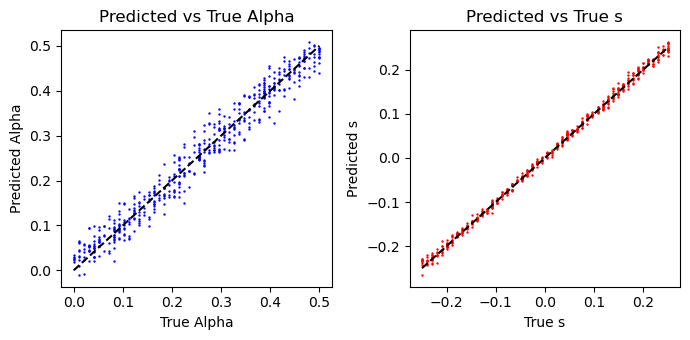

In [20]:
import matplotlib.pyplot as plt

true_values = target_scaler.inverse_transform(y_test)

# Select the number of points to plot
num_points_to_plot = len(X_test)

# Plotting the first few predictions vs true values for both alpha and s
plt.figure(figsize=(7, 3.5))

# Plot for alpha
plt.subplot(1, 2, 1)
plt.scatter(true_values[:num_points_to_plot, 0], predictions[:num_points_to_plot, 0], color='blue', s= 0.5)
plt.plot([0, .5], [0, .5], 'k--')
plt.xlabel('True Alpha')
plt.ylabel('Predicted Alpha')
plt.title('Predicted vs True Alpha')

# Plot for s
plt.subplot(1, 2, 2)
plt.scatter(true_values[:num_points_to_plot, 1], predictions[:num_points_to_plot, 1], color='red', s = 0.5)
plt.plot([-0.25, 0.25], [-0.25, 0.25], 'k--')
plt.xlabel('True s')
plt.ylabel('Predicted s')
plt.title('Predicted vs True s')
plt.tight_layout()
plt.savefig("nn_acc.png")
plt.show()

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Making predictions on the test set
predictions = rgs.predict(X_test)
predictions = target_scaler.inverse_transform(predictions)  # Convert predictions back to original scale

# Splitting predictions into alpha and s components
predicted_alphas = predictions[:, 0]
predicted_ses = predictions[:, 1]

# Splitting true values into alpha and s components
true_alphas = target_scaler.inverse_transform(y_test)[:, 0]
true_ses = target_scaler.inverse_transform(y_test)[:, 1]

# Calculate and print error metrics for alpha
mae_alpha = mean_absolute_error(true_alphas, predicted_alphas)
rmse_alpha = np.sqrt(mean_squared_error(true_alphas, predicted_alphas))
print(f"Alpha - Mean Absolute Error: {mae_alpha}, Root Mean Squared Error: {rmse_alpha}")

# Calculate and print error metrics for s
mae_s = mean_absolute_error(true_ses, predicted_ses)
rmse_s = np.sqrt(mean_squared_error(true_ses, predicted_ses))
print(f"s - Mean Absolute Error: {mae_s}, Root Mean Squared Error: {rmse_s}")

Alpha - Mean Absolute Error: 0.021255951700682126, Root Mean Squared Error: 0.026545416169451743
s - Mean Absolute Error: 0.005842695986150747, Root Mean Squared Error: 0.007425066654296498


In [55]:
# Transforms the frequencies to a list of repeated numbers, to calculate summary statistics
def freq_to_count(y):
    y_list = []
    for i in range(len(y)):
        y_list += y[i]*[i]  
    return y_list 

def summary_statistics(data):
    # Some summary statistics. Skew gives some kind of distribution atleast, see plot in last cell
    mean = np.mean(data)
    std = np.std(data)
    skewness = skew(data)
    mode_value = mode(data, keepdims=True).mode[0]
    return np.array([mean, std, skewness, mode_value])

def gaussian_kernel(dist, h):
    return np.exp(-dist**2 / (2 * h**2))

def biweight_kernel(dist, h):
    if abs(dist) <= h:
        return 15/16 * ((1 - (dist / h) ** 2) ** 2)
    else:
        return 0

def abc_rejection_sampling(data_obs, h, num_simulations=10, rgs = None, prior = None, repeats=0):
    accepted_alphas = []
    random_s = []
    acceptance_ratios = []
    stds = []
    # Sets the first normal distribution, large var to approach uniform dist.
    if prior == None:
        mean_val = 0.25
        std_val = 10
        skew_val = 0
        #prior = uniform(a=0,b=0.5)
    else:
        [mean_val, std_val, skew_val, mode_val] = summary_statistics(prior)
    
    # Loop over the number of simulations
    for ix in tqdm(range(repeats)):
        tmp_accepted_alphas = []
        tmp_random_s = []
        for jx in tqdm(range(num_simulations)):
            observed_exp = experiment().astype(int)  # Generate experiment data, see code above
            observed_exp_list = freq_to_count(observed_exp)
            
            # alpha governs the variance
            ss_obs = summary_statistics(observed_exp_list)[1]
        
            # Randomly sample alpha, within bounds
            alpha = 1
            while alpha < 0 or alpha > 0.5:
                alpha = skewnorm.rvs(a=skew_val,loc=mean_val,scale=std_val)
            
            # Uses ML model if available, otherwise random uniform
            if rgs != None:
                observed_exp = observed_exp.reshape(1,-1)
                observed_exp = X_scaler.transform(observed_exp)
                ret = rgs.predict(observed_exp)
                ret = target_scaler.inverse_transform(ret)
                s_mean = ret[0,1]
                s = 1 
                while np.abs(s) > 0.25:
                    s = norm.rvs(loc = s_mean, scale = rmse_s)
            else:
                s = np.random.uniform(-0.25, 0.25)
            tmp_random_s.append(s)

            # Simulate an experiment with the sampled parameters
            sim_exp = simulate_exp(alpha, s)
            sim_exp_list = freq_to_count(sim_exp)
            ss_exp = summary_statistics(sim_exp_list)[1]

            dist = ss_obs - ss_exp
            
            # Calculate kernel
            w = biweight_kernel(dist, h)
            
            # Acceptance probability from algorithm 5 in chapter 10
            if rgs != None:
                s_dist = norm.pdf(s, loc = s_mean, scale = rmse_s)
                a_dist = skewnorm.pdf(alpha,a=skew_val,loc=mean_val,scale=std_val)
                m = biweight_kernel(0,h)*skewnorm.pdf(mean_val, a=skew_val, loc=mean_val, scale=std_val)*norm.pdf(s_mean, loc=s_mean, scale=rmse_s)
                p = w*a_dist*(s_dist/m)
                if p > np.random.uniform(0, 1):
                    tmp_accepted_alphas.append(alpha)
            # w is higher than a random threshold, accept alpha
            else:    
                if w > np.random.uniform(0, 1):
                    tmp_accepted_alphas.append(alpha)
        # Use the accepted alphas to create a prior, assumed skewed normal
        old_std_val = std_val
        [mean_val, std_val, skew_val, mode_val] = summary_statistics(tmp_accepted_alphas)
        stds.append(std_val)
        acceptance_ratio = len(tmp_accepted_alphas)/num_simulations
        acceptance_ratios.append(acceptance_ratio)
        accepted_alphas.append(tmp_accepted_alphas)
        random_s.append(tmp_random_s)
        
        # Dynamically change h
        std_ratio = std_val/old_std_val
        if std_ratio < 1 and acceptance_ratio > 0.5:
            h *= 0.9
        else:
            h *= 1.1

        # The acceptance ratio should probabli be aroun 50%
        print(f"Accepted: {acceptance_ratio*100}%")


    return accepted_alphas, acceptance_ratios, random_s, stds

Mean var skew mode
[15.677       2.77788967  0.04451156 15.        ]
Mean var skew mode
[15.483       4.79183796  0.09469159 15.        ]


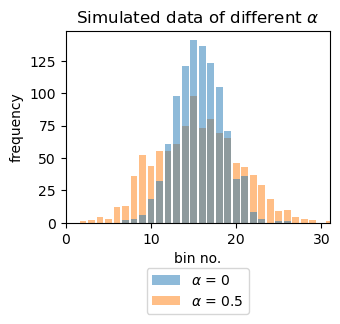

In [23]:
# Plot histogram for different alpha
alpha_1 = 0
alpha_2 = 0.5
y_1 = simulate_exp(0, 0)
y_list_1 = freq_to_count(y_1)
y_2 = simulate_exp(0.5, 0)
y_list_2 = freq_to_count(y_2)

print("Mean var skew mode")
print(summary_statistics(y_list_1))
print("Mean var skew mode")
print(summary_statistics(y_list_2))
x = experiment_data[0]

fig = plt.figure(figsize=(3.5,3.5))
plt.bar(np.arange(0,32),y_1, label=r"$\alpha$ = 0",zorder = 2, alpha = 0.5)
plt.bar(np.arange(0,32),y_2, label=r"$\alpha$ = 0.5", zorder = 1, alpha = 0.5)
plt.xlim(0,31)
plt.xlabel('bin no.')
plt.ylabel('frequency')
plt.title(r"Simulated data of different $\alpha$")
plt.legend(loc = 'upper center',bbox_to_anchor = (0.5,-0.2))

plt.tight_layout()
plt.savefig("different_alpha.png")

In [60]:
i_experiment = 0
num_simulations = 100
# Since the variance is used, h needs to be in scale of "number of beads off in the variance"
h = 1.5
repeats = 9
print(len(experiment_data))

# Run the sampling!
accepted_alphas, acc_ratios, proposed_ses, stds = abc_rejection_sampling(experiment_data, h, num_simulations, 
                                                                              rgs=rgs, repeats = repeats)

1000


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.31847976913337867
0.26994262769805855 0.13314293983622413 -0.12250962378129918 0.017468265059522398
1.5
Accepted: 57.99999999999999%


  0%|          | 0/100 [00:00<?, ?it/s]

0.31568181120992067
0.2609411644235278 0.08086468571766277 0.1769066482711555 0.0956351993513622
1.35
Accepted: 48.0%


  0%|          | 0/100 [00:00<?, ?it/s]

0.31363567758172356
0.2759944449896096 0.06282839696972861 0.3231336693730069 0.15038653490441262
1.4850000000000003
Accepted: 53.0%


  0%|          | 0/100 [00:00<?, ?it/s]

0.33116886233932613
0.2901199313380561 0.033752379563089255 0.17296509261961432 0.21299870323585568
1.3365000000000002
Accepted: 50.0%


  0%|          | 0/100 [00:00<?, ?it/s]

0.3379454301948834
0.30296905665130375 0.02273074277070038 0.8160354563687775 0.26171402099820745
1.4701500000000003
Accepted: 61.0%


  0%|          | 0/100 [00:00<?, ?it/s]

0.31376833182029246
0.3145118907441381 0.014592924812239476 0.6149199967550345 0.2889322754975272
1.3231350000000004
Accepted: 68.0%


  0%|          | 0/100 [00:00<?, ?it/s]

0.3207698934867698
0.3217602943055674 0.007109556987013217 0.5986173593837252 0.30882760737564213
1.1908215000000004
Accepted: 56.99999999999999%


  0%|          | 0/100 [00:00<?, ?it/s]

0.3327116186360966
0.3229068638495659 0.004865977399444906 0.678788003156308 0.31473286363570957
1.0717393500000003
Accepted: 56.00000000000001%


  0%|          | 0/100 [00:00<?, ?it/s]

0.3301137830433609
0.3253884916987924 0.0033989237316101586 0.11300665745491496 0.3186673331262806
0.9645654150000003
Accepted: 51.0%


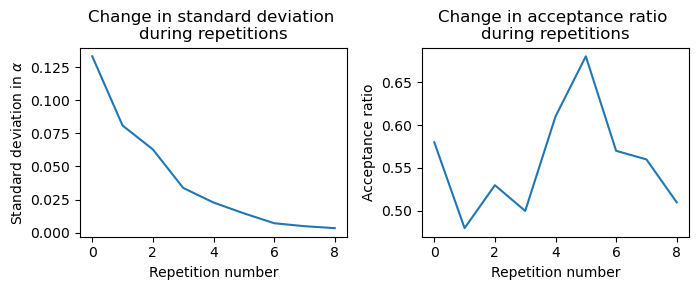

In [61]:
# Plot the standard variance per repetition
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(stds)
plt.xlabel("Repetition number")
plt.ylabel(r"Standard deviation in $\alpha$")
plt.title("Change in standard deviation \nduring repetitions")

plt.subplot(1,2,2)
plt.plot(acc_ratios)
plt.xlabel("Repetition number")
plt.ylabel(r"Acceptance ratio")
plt.title("Change in acceptance ratio \nduring repetitions")
plt.tight_layout()
plt.savefig("ABC_refined.png")
plt.show()

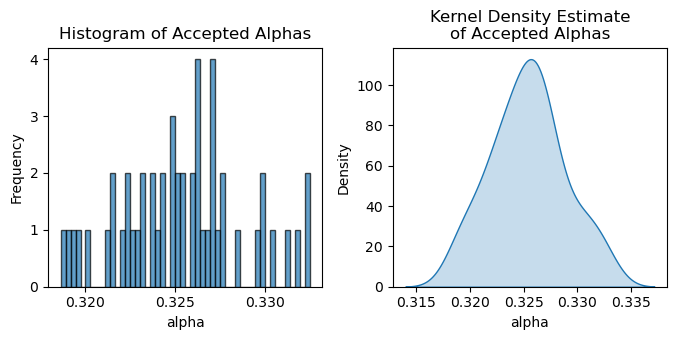

In [62]:
# Take the last iteration of alphas
flat_accepted_alphas = accepted_alphas[-1]

# Plotting
plt.figure(figsize=(7, 3.5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(flat_accepted_alphas, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('alpha')
plt.ylabel('Frequency')
plt.title('Histogram of Accepted Alphas')
plt.ticklabel_format(useOffset=False)

# Kernel Density Estimate Plot
plt.subplot(1, 2, 2)
sns.kdeplot(flat_accepted_alphas, fill=True)
plt.xlabel('alpha')
plt.title('Kernel Density Estimate\nof Accepted Alphas')
plt.ticklabel_format(useOffset=False)
plt.tight_layout()
plt.savefig("accepted_alphas.png")
plt.show()


Median:0.3254182389781984 ((0.31956208079035164, 0.33151068674273965))


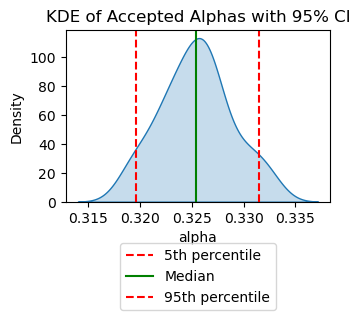

In [63]:
import numpy as np

# Calculate percentiles
lower_percentile = np.percentile(flat_accepted_alphas, 5)
median = np.percentile(flat_accepted_alphas, 50)
upper_percentile = np.percentile(flat_accepted_alphas, 95)

print(f'Median:{median} ({lower_percentile, upper_percentile})')

fig = plt.figure(figsize=(3.5,3.5))
sns.kdeplot(flat_accepted_alphas, fill=True)
plt.axvline(lower_percentile, color='red', linestyle='--', label='5th percentile')
plt.axvline(median, color='green', linestyle='-', label='Median')
plt.axvline(upper_percentile, color='red', linestyle='--', label='95th percentile')
plt.xlabel('alpha')
plt.title('KDE of Accepted Alphas with 95% CI')
plt.legend(loc = 'upper center',bbox_to_anchor = (0.5,-0.2))
plt.tight_layout()
plt.savefig("alpha_ci.png")
plt.show()